In [1]:
# Leolin Kamto's implementation for Blockhouse assessment, December 2024
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import gamma as gamma_func  # Gamma function
import torch
import torch.nn as nn
import torch.optim as optim

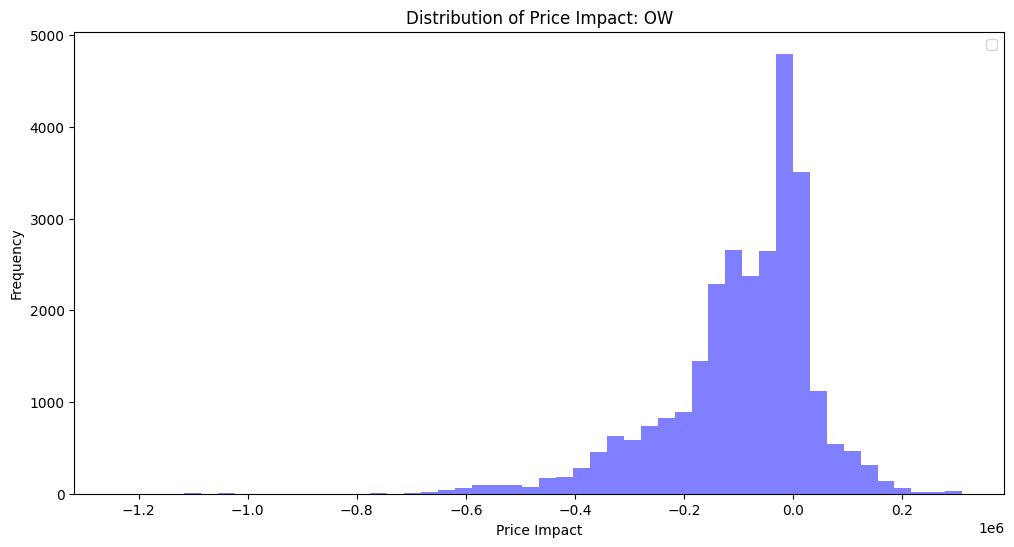

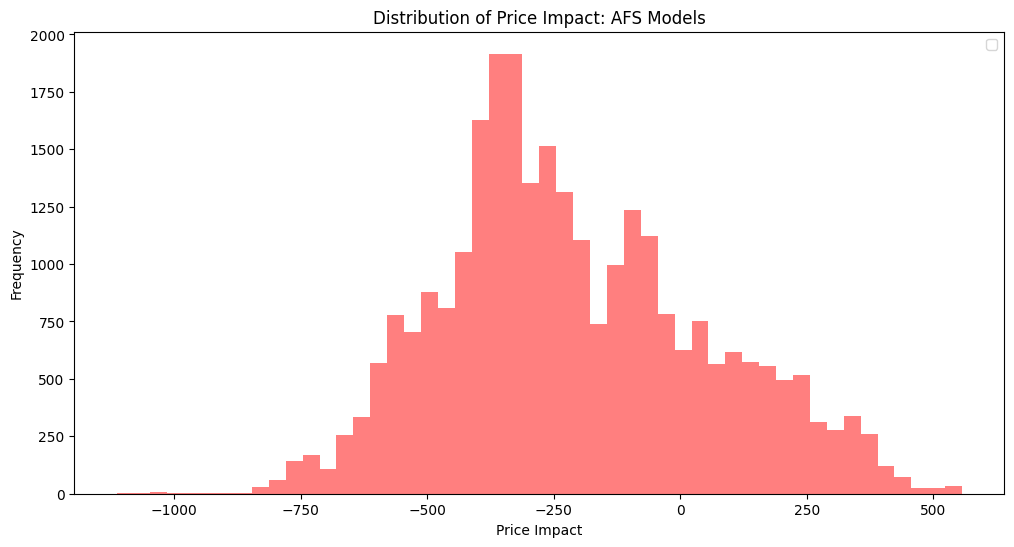

In [4]:
# Load the dataset
data = pd.read_csv("/content/merged_data.csv")

# Convert timestamps to datetime format
data['ts_event'] = pd.to_datetime(data['ts_event'])

# Compute signed volume and mid-price
data['mid_price'] = (data['best_bid'] + data['best_ask']) / 2
data['Signed Volume'] = data['bid_fill'] - data['ask_fill']

# Define the propagator kernel (exponential decay)
def propagator_kernel(t_diff, beta=0.01):
    """Exponential decay kernel."""
    return np.exp(-beta * t_diff)

# Compute J_t^n (impact state)
def compute_impact_state(data, kernel_func, beta=0.01):
    """
    Compute the impact state J_t for all timestamps.
    """
    J = np.zeros(len(data))
    for i in range(1, len(data)):
        t_i = data['ts_event'].iloc[i]
        time_diffs = (t_i - data['ts_event'][:i]).dt.total_seconds()
        volumes = data['Signed Volume'][:i]

        # Apply the kernel to compute J_t^n
        J[i] = np.sum(kernel_func(time_diffs, beta) * volumes)
    return J

# Compute price impact (I_t)
def compute_price_impact(J, lambda_=1, p=None):
    """
    Compute price impact I_t from the impact state J_t.
    """
    if p is None:
        # Linear impact function (OW model)
        return lambda_ * J
    else:
        # Nonlinear impact function (AFS model)
        return lambda_ * np.sign(J) * np.abs(J)**p

# Parameters
beta = 0.01  # Decay rate
lambda_ = 1  # Impact factor
p = 0.5      # Nonlinearity parameter for AFS model

# Compute J_t for both models
data['J_t'] = compute_impact_state(data, propagator_kernel, beta=beta)

# Compute price impacts for OW (linear) and AFS (nonlinear) models
data['OW_Impact'] = compute_price_impact(data['J_t'], lambda_=lambda_)
data['AFS_Impact'] = compute_price_impact(data['J_t'], lambda_=lambda_, p=p)

# Visualize the distribution of price impacts for OW model
plt.figure(figsize=(12, 6))
plt.hist(data['OW_Impact'], bins=50, alpha=0.5, color='blue')
plt.title("Distribution of Price Impact: OW")
plt.xlabel("Price Impact")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Visualize the distribution of price impacts for AFS model
plt.figure(figsize=(12, 6))
plt.hist(data['AFS_Impact'], bins=50, alpha=0.5, color='red')
plt.title("Distribution of Price Impact: AFS Models")
plt.xlabel("Price Impact")
plt.ylabel("Frequency")
plt.legend()
plt.show()

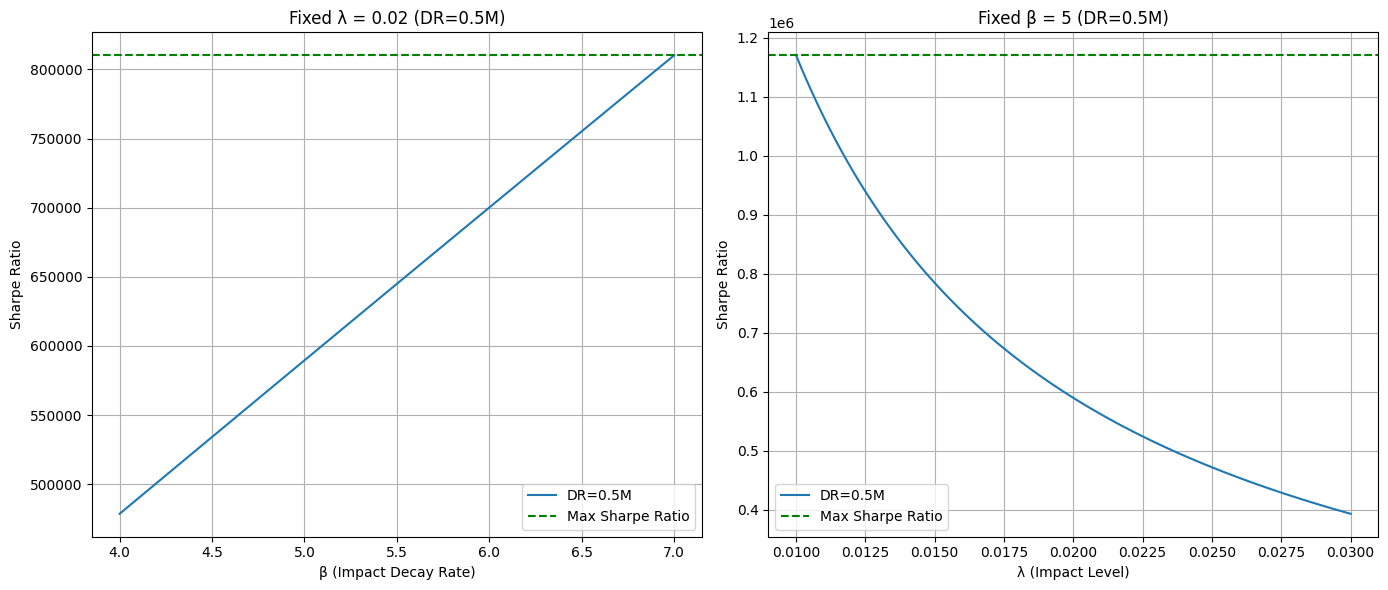

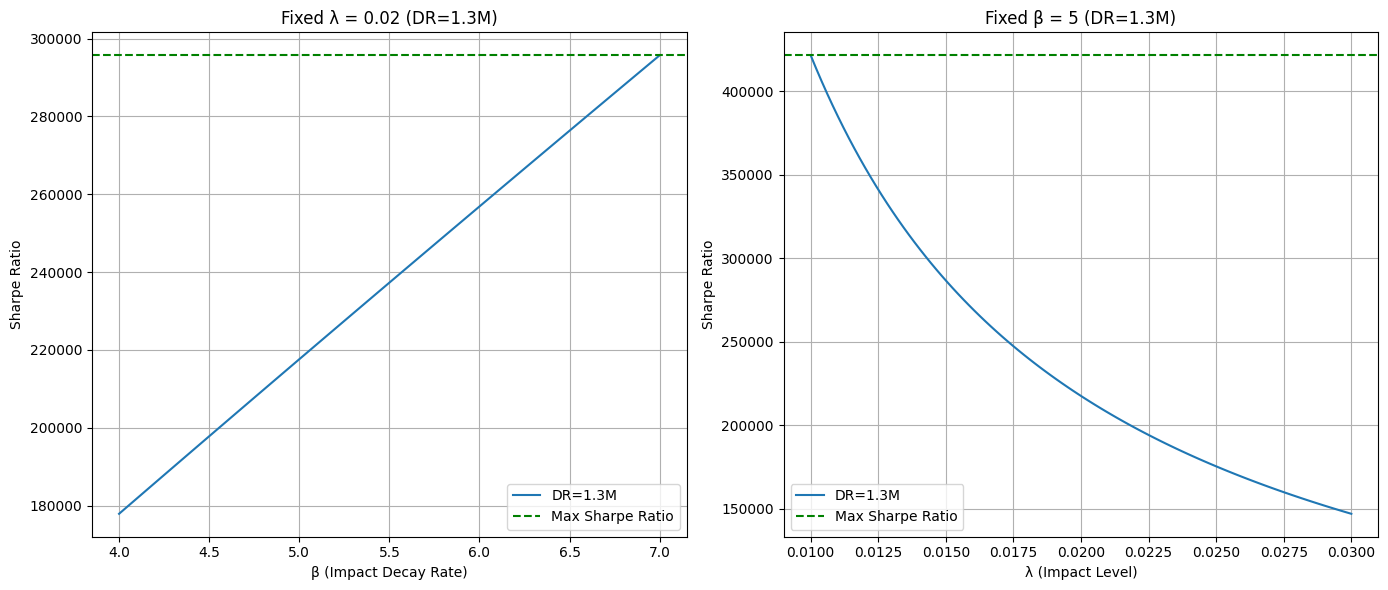

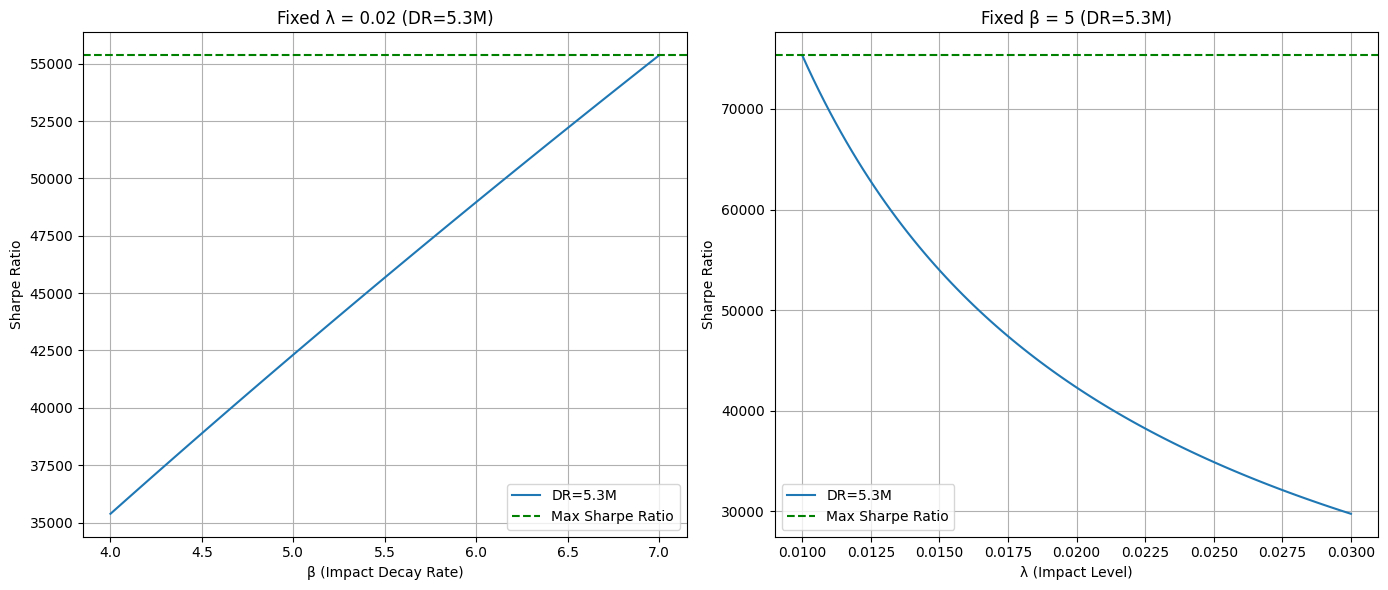

In [5]:
# Parameters
Q = 560e6  # Total position size (in dollars)
N = 500  # Number of uncorrelated assets
gamma_param = 1e-4  # Risk aversion parameter
phi = 0.139  # Mean reversion rate
DR_values = [0.5e6, 1.3e6, 5.3e6]  # Risk budgets (in millions)
SR_frictionless = 3  # Sharpe Ratio without friction

# β (Impact Decay Rate) and λ (Impact Level) ranges
beta_values = np.linspace(4, 7, 100)  # β range
lambda_values = np.linspace(0.01, 0.03, 100)  # λ range
p_n = np.linspace(0.1, 1, N)  # Example p_n sequence for the sum

# Function to compute xi
def compute_xi(gamma_param, sigma, beta, lambda_):
    return np.sqrt(gamma_param * sigma**2 * (gamma_param * sigma**2 + 2 * lambda_ * beta))

# Function to compute PnL with corrected indexing and varying DR
def compute_pnl(alpha, beta, lambda_, gamma_param, phi, sigma, xi):
    # First term
    pnl_term1 = (alpha**2 * gamma_param**2 * (beta + phi)**2) / (gamma_param * beta * sigma**2 + xi * phi)**2

    # Second term: Sum over n
    pnl_term2 = 0
    for n in range(1, N + 1):
        beta_n = beta  # Assume beta_n = beta for now (can be generalized)
        lambda_n = lambda_  # Assume lambda_n = lambda_
        phi_n = phi  # Assume phi_n = phi

        gamma_factor = gamma_func(p_n[n - 1] / 2)  # Gamma function
        numerator = (2 * alpha**2 * gamma_param**2 * sigma**4 * phi * (beta + phi)**2 +
                     (beta**2 * xi + beta_n * phi_n * xi +
                      gamma_param * beta * sigma**2 * (beta_n + phi_n)))
        denominator = (xi * (beta_n + phi) *
                       (gamma_param * beta * sigma**2 + beta_n * xi) *
                       (phi * xi + gamma_param * beta * sigma**2)**3)
        fraction = (numerator / denominator) ** (p_n[n - 1] / 2)

        pnl_term2 += gamma_factor * p_n[n - 1] * beta_n * lambda_n / (2 * np.sqrt(np.pi)) * fraction

    return pnl_term1 - pnl_term2

# Generate Sharpe Ratio plots
for DR in DR_values:
    sigma = DR / (Q / np.sqrt(N))  # Recalculate sigma for the given DR
    alpha = SR_frictionless * (sigma * np.sqrt(N)) / gamma_param  # Adjust alpha for Sharpe Ratio
    #sigma = 0.02
    plt.figure(figsize=(14, 6))

    # Plot 1: Fix λ and vary β
    sharpe_ratios_lambda_fixed = []
    lambda_fixed = 0.02  # Fix λ at 0.02
    for beta in beta_values:
        xi = compute_xi(gamma_param, sigma, beta, lambda_fixed)
        PnL = compute_pnl(alpha, beta, lambda_fixed, gamma_param, phi, sigma, xi)
        sharpe_ratio = PnL / DR  # Sharpe Ratio calculation
        sharpe_ratios_lambda_fixed.append(sharpe_ratio)

    plt.subplot(1, 2, 1)
    plt.plot(beta_values, sharpe_ratios_lambda_fixed, label=f'DR={DR / 1e6}M')
    plt.axhline(y=max(sharpe_ratios_lambda_fixed), color='green', linestyle='--', label='Max Sharpe Ratio')
    plt.xlabel('β (Impact Decay Rate)')
    plt.ylabel('Sharpe Ratio')
    plt.title(f'Fixed λ = {lambda_fixed} (DR={DR / 1e6}M)')
    plt.grid(True)
    plt.legend()

    # Plot 2: Fix β and vary λ
    sharpe_ratios_beta_fixed = []
    beta_fixed = 5  # Fix β at 5
    for lambda_ in lambda_values:
        xi = compute_xi(gamma_param, sigma, beta_fixed, lambda_)
        PnL = compute_pnl(alpha, beta_fixed, lambda_, gamma_param, phi, sigma, xi)
        sharpe_ratio = PnL / DR  # Sharpe Ratio calculation
        sharpe_ratios_beta_fixed.append(sharpe_ratio)

    plt.subplot(1, 2, 2)
    plt.plot(lambda_values, sharpe_ratios_beta_fixed, label=f'DR={DR / 1e6}M')
    plt.axhline(y=max(sharpe_ratios_beta_fixed), color='green', linestyle='--', label='Max Sharpe Ratio')
    plt.xlabel('λ (Impact Level)')
    plt.ylabel('Sharpe Ratio')
    plt.title(f'Fixed β = {beta_fixed} (DR={DR / 1e6}M)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

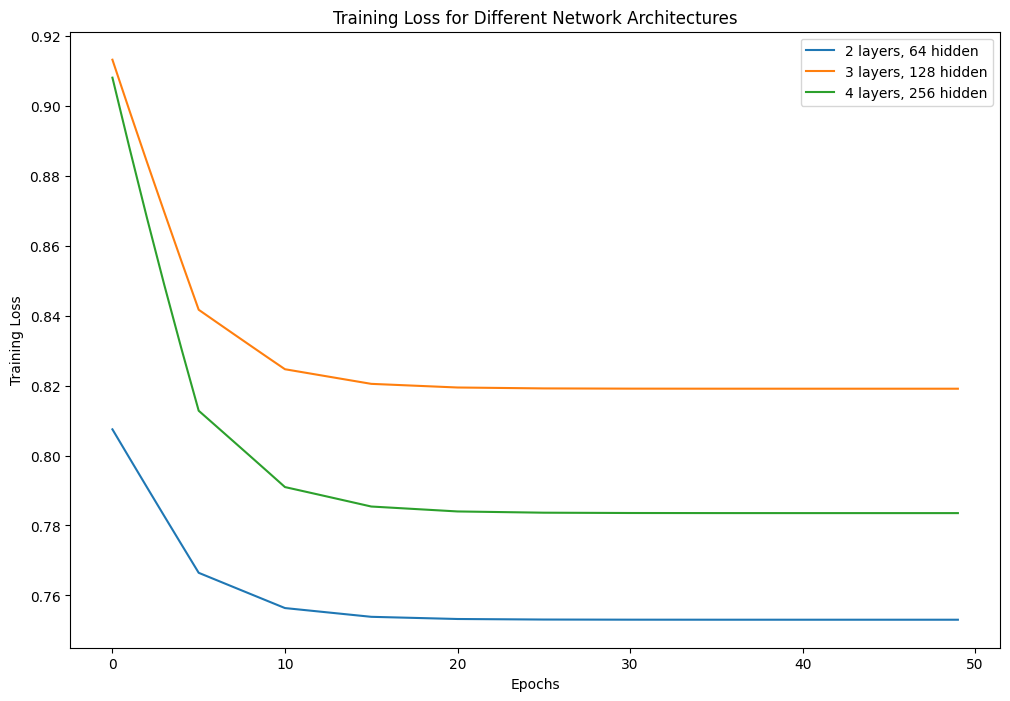

In [6]:
# Device configuration (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate synthetic trading data based on f_n dynamics
def generate_synthetic_data(n_samples, T, theta, delta_t):
    """
    Generates synthetic data using the dynamics:
    f_n = exp(-theta * delta_t) * f_{n-1} + sqrt(1 - exp(-2 * theta * delta_t)) * Z_n
    where Z_n ~ N(0, 1).
    """
    f = np.zeros((n_samples, T))
    for t in range(1, T):
        f[:, t] = (
            np.exp(-theta * delta_t) * f[:, t - 1]
            + np.sqrt(1 - np.exp(-2 * theta * delta_t)) * np.random.normal(0, 1, n_samples)
        )
    return f

# Define the trading network
class TradingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(TradingNetwork, self).__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Function to update the covariance matrix
def update_covariance(cov_prev, samples):
    """
    Updates the covariance matrix using a moving average:
    Cov_new = 0.999 * Cov_prev + 0.001 * Cov_sample
    """
    cov_sample = np.cov(samples, rowvar=False)
    return 0.999 * cov_prev + 0.001 * cov_sample

# Parameters
n_samples = 1024
T = 5120
theta = 0.1
delta_t = 0.01
batch_size = 1024
epochs = 50
learning_rate = 1e-4

# Generate synthetic data
data = generate_synthetic_data(n_samples, T, theta, delta_t)
data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

# Initial covariance matrix (3x3 for [f_n, Q_n, J_n])
cov_matrix = np.eye(3)

# Network architectures
network_architectures = [(2, 64), (3, 128), (4, 256)]  # (n_layers, hidden_dim)
losses = {}

# Loop through different architectures
for n_layers, hidden_dim in network_architectures:
    # Initialize the network and optimizer
    model = TradingNetwork(input_dim=1, hidden_dim=hidden_dim, output_dim=1, n_layers=n_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Training loop
    epoch_losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Sample a batch of data
        indices = np.random.choice(n_samples, batch_size, replace=False)
        input_data = data_tensor[indices, :-1]  # Input: f_n
        target_data = data_tensor[indices, 1:]  # Target: f_{n+1}

        # Forward pass
        outputs = model(input_data.unsqueeze(-1))
        loss = loss_fn(outputs.squeeze(-1), target_data)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update covariance matrix
        Q_n = np.zeros((batch_size, 1))  # Placeholder for Q_n
        J_n = np.zeros((batch_size, 1))  # Placeholder for J_n

        # Concatenate f_n, Q_n, and J_n to form (batch_size, 3)
        f_samples = np.hstack([input_data.cpu().numpy()[:, -1:], Q_n, J_n])
        cov_matrix = update_covariance(cov_matrix, f_samples)

        epoch_losses.append(loss.item())

        # Adjust learning rate every 5 epochs
        if (epoch + 1) % 5 == 0:
            for param_group in optimizer.param_groups:
                param_group["lr"] *= 0.25

    losses[f'{n_layers} layers, {hidden_dim} hidden'] = epoch_losses

# Plot training losses
plt.figure(figsize=(12, 8))
for label, epoch_losses in losses.items():
    plt.plot(epoch_losses, label=label)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss for Different Network Architectures')
plt.legend()
plt.show()